# Aircrew trainee scheduling with seniority constraints
[![tip8_aircrew_trainees_seniority.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb)](https://colab.ampl.com)

Description: Aircrew trainee scheduling with simpler seniority modeling

Tags: trainee scheduling, aircrew scheduling, employee scheduling, seniority constraints, seniority ranking, multiple objectives, lexicographic optimization, amplpy

Notebook author: Gleb Belov <<gleb@ampl.com>>

References:
1. Kozanidis, G. (2017). Optimal assignment of aircrew trainees to simulator and classroom training sessions subject to seniority and preference restrictions. Journal of Air Transport Management 59, 143-154.
2. Gamache, M., Soumis, F., Villeneuve, D., Desrosiers, J., & Gélinas, É. (1998). The preferential bidding system at Air Canada. Transportation Science, 32(3), 246-255.
3. Achour, H., Gamache, M., Soumis, F., & Desaulniers, G. (2007). An exact solution approach for the preferential bidding system problem in the airline industry. Transportation Science, 41(3), 354-365.

In [1]:
# Install dependencies
%pip install -q amplpy pandas matplotlib tabulate

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
SOLVER = "highs"             # Select solver: highs, gurobi, copt, cplexmp, ...
                             # When running locally and solver is installed,
                             # don't need the "modules" and "license_uuid" in ampl_notebook

## Problem statement

This notebook considers a realistic trainee scheduling model from [1] involving classroom capacities, language and (reverse) seniority constraints, and seniority-ranked preferences. The seniority constraints are modeled simply and efficiently by Preferential Bidding System (PBS)-style secondary objective functions. In the next section we walk through a small example illustrating the new approach, as well as a contradiction between the direct preferences and reverse seniority.

**Sets:**
- $I$ - set of crew trainees,
- $T$ - set of training sessions,
- $V_i$ - set of valid sessions of trainee $i\in I$,
- $Pos$ - set of crew positions:  captain (CP), first officer (FO), purser (PU), or flight attendant (FA),
- $Grp$ - set of trainee groups: all, cockpit (CK), cabin (CB).

**Parameters:**
- $P_i\in Pos$ - position of trainee $i\in I$,
- $S_i$ - seniority. The smaller this number, the more senior the corresponding crew member,
- $E_i$ - flight capability expiration. 0: end of the current month, 1: end of the next month, 2: end of the next to the following month,
- $L_i$ - spoken language. 0: the trainee speaks both of the alternative languages, 1: only the first language, 2: only the second language,
- $Pr_{it}$ - priority of trainee $i$ for valid session $t$. Priorities are non-negative integers. Higher priorities mean higher preference. Zero priority means that the trainee does not want to be assigned to this session. All positive priorities for the same trainee should be different, while zero priority can be expressed for multiple sessions,
- $MAX_p$ - capacity of each training session for trainees of position $p\in Pos$,
- $MAX^+_g$ - capacity of each training session for trainees of group $g\in Grp$.

The aim is to find an optimal assignment of trainees to training sessions which minimizes the number of training slots that remain empty, while also satisfying a list of hard and soft requirements. The satisfaction of the hard restrictions is unnegotiable, whereas the soft ones must be satisfied to the greatest possible extent. The **hard restrictions** that must be satisfied are the following:
- Capacity constraints for each training session,
- One of the two alternative languages must be selected for each session,
- Every crew member with expiration 0 must be assigned to one of his/her valid sessions,
- Reverse expiration and reverse seniority restrictions. Suppose that there exists a slot in a training session, which is only valid to a specific subset of crew members, none of which has expressed positive preference for being assigned to this session. Since the minimization of the total number of empty slots is the model's primary objective, one of these crew members must eventually be assigned to this session. The reverse expiration restrictions, considered first, dictate that this should be the crew member with the lowest expiration (his/her flight capability should expire sooner) among them. Assume now, that two or more trainees have the lowest expiration. The reverse seniority restrictions, considered next, dictate that this should be the least senior trainee among all the trainees with the lowest expiration. Such restrictions can be called "expiration- and seniority-ranked anti-preferences".

Additionally, the following **soft restrictions** must be satisfied:
- The maximum possible preference satisfaction for each crew member must be attained, according to strict seniority. This means that no crew member's preference should be satisfied at the expense of the dissatisfaction of a more senior crew member's preference.
- The maximum possible preference satisfaction of each individual crew member must be attained, according to the list of priorities that he/she has expressed.

**Decision variables:**
- $x_{it}$ - binary decision variable, takes value $1$ *iff* trainee $i\in I$ is assigned to session $t\in V_t$,
- $y_i$ - binary decision variable that takes the value 1 *iff* trainee i remains unassigned, $i\in I$: $E_i = 1$ or $2$,
- $u_t$: binary decision variable that takes the value 1 if language 1 is selected for training session t, and 0 if language 2 is selected instead, $t\in T$,
- $w$: total number of crew trainees that remain unassigned.

The **optimization model**, formulated below in AMPL, follows [1], while differs as follows:
- The reverse expiration and seniority constraints ("anti-peferences") are sublimated via Preferential Bidding System (PBS)-style secondary objective functions. Minimizing the objective functions `ReverseSeniority[]` aims to satisfy constraints (8), (9), (22-25), and (26--29) from [1], as well as to resolve the 'pitfall' from Section 3.1.
- The lexicographic approach for (anti-)preference ranking by seniority is implemented via multiple objectives submitted to the solver in a single model.
No variables are fixed while optimizing the different objectives.

## A step-by-step example

This example illustrates the multi-objective approach, as well as shows a possible contradiction between the preferences and reverse seniority relations, not menitioned in [1].

Assume we have 3 trainees, 1 time slot, and the class capacity is 2. Thus, at most 2 trainees will be scheduled.

Trainees' input data:
|  Trainee   |   Position P[i] |   Seniority S[i] |   Language L[i] |   Expiration E[i] | Session priorities Pr[i, t]     | Feasible sessions V[i]    |
|-----------:|------:|------:|------:|------:|:-------------------------|:-------------|
|  1         |     1 |     5 |     0 |     1 | [0] | [1]       |
|  2         |     1 |    63 |     0 |     0 | [1] | [1]       |
|  3         |     1 |    89 |     0 |     2 | [0] | [1]       |

I.e., all 3 trainees have the same position; they are ordered by falling seniority; all can speak both languages; Trainee 2's license expires this month, while others' later; Trainee 2 is ok with the single available session, while others don't want it.

The multi-objective model below results in the following stepwise optimization process.

- **Step 1.** Minimize the number of unassigned trainees, giving $w=1$.
- **Step 2.** Maximize preferences of the most-senior Trainee 1. Because being not assigned is preferred to an unwanted assignment, "not assigned" ($y_1=1$) is the outcome.
- **Step 3.** Maximize preferences of Trainee 2. They are assigned.
- **Step 4.** Maximize preferences of Trainee 3. While they don't want, they are assigned due to the fixed $w=1$. 

Next follow the new PBS objectives sublimating the strict reverse seniority constraints.

- **Step 5.** For trainees expiring next month (Trainee 1), maximize the assignments in the increasing order of seniority. This normally results in the reverse expiration and reverse seniority constraints being satisfied: if the trainee has unwanted slots, they could be assigned there, letting the more-senior and longer-expiring trainees go free.

But in this case, Trainee 1 cannot be assigned due to Step 2.
- **Step 6.** Similar to Step 5, but for trainees expiring in 2 months. Makes no changes in this example.
- **Step 7** *(optional.)* Minimize session load disbalances.

If we enforced the reverse expiration and seniority as strict constraints, they would lead to assignment of Trainee 1 (reverse expiration means it is preferred over Trainee 3), thus violating Trainee 1's direct preferences. For the larger examples below, subsection Discussion investigates the contradictions if present.

## Test instance generation

Define class `Instance` holding a problem instance.

In [4]:
import math
import numpy as np
import pandas as pd

class Instance:
    def __init__(self):
        ## Data arrays / matrices for all trainees
        self.nT = 0
        self.P = []
        self.S = []
        self.L = []
        self.E = []
        self.V = []
        self.Pr = []
        ## Capacity constraints
        self.cap_kind = []
        self.MAX = []
        self.cap_plus_kind = []
        self.cap_plus_which = []
        self.MAXPlus = []

    def ToPandas(self):
        data = {
            "Pos": self.P,
            "Sen": self.S,
            "Lng": self.L,
            "Exp": self.E,
            "Pri": [ [ round(pr) for pr in PrI ] for PrI in self.Pr ],
            "V": [ sorted([ v-1 for v in Vi ]) for Vi in self.V ]
        }
        df = pd.DataFrame(data)
        return df  

Define class `InstGenParams` with instance generation parameters according to [1], but with a smaller ration of classes to trainees (originally 1/5.)

In [5]:
class InstGenParams:
    def __init__(self, N, T):
        self.N = N
        self.T = T  # Set lower to have non-assignments
        ## Ranges and probabilities
        self.position_kind = ["CP", "FO", "PU", "FA"]
        self.position_prob = [0.25, 0.25, 0.25, 0.25]
        self.language_prob = [0.5, 0.25, 0.25]
        self.expiration_prob = [0.5, 0.25, 0.25]
        self.N_sess_rng = [1, math.floor(self.T / 2)]
        self.pref_0 = 0.5
        ## These are constant for all instances
        self.cap_kind = ["CP", "FO", "PU", "FA"]
        self.MAX = [4, 4, 4, 4]
        self.cap_plus_kind = ["All", "CK", "CB"]
        self.cap_plus_which = [[1, 2], [1, 2], [1, 3], [1, 3]]
        self.MAXPlus = [10, 6, 6]

Function to generate an instance.

In [6]:
def GenInstance(genpar, rng):
    inst = Instance()
    inst.nT = genpar.T
    inst.S = np.arange(genpar.N)  # Seniority 0..N-1
    rng.shuffle(inst.S)
    for itr in range(0, genpar.N):
        inst.P.append(
            rng.choice(
                np.arange(1, len(genpar.position_prob) + 1),  # 1-based
                p=genpar.position_prob,
            )
        )
        inst.L.append(rng.choice(len(genpar.language_prob), p=genpar.language_prob))
        inst.E.append(rng.choice(len(genpar.expiration_prob), p=genpar.expiration_prob))
        N_feas_sess = rng.integers(genpar.N_sess_rng[0], genpar.N_sess_rng[1] + 1)
        V = rng.choice(
            np.arange(1, genpar.T + 1), size=N_feas_sess, replace=False  # 1-based
        )
        inst.V.append(V)
        N_pr_0 = rng.binomial(N_feas_sess, genpar.pref_0)
        PrByV = np.concatenate(
            (np.zeros(N_pr_0), np.arange(1, N_feas_sess - N_pr_0 + 1))
        )
        assert N_feas_sess == len(PrByV)
        rng.shuffle(PrByV)
        Pr = np.zeros(genpar.T)
        for k, t in enumerate(V):
            Pr[t - 1] = PrByV[k]
        inst.Pr.append(Pr)
    # Capacities
    inst.cap_kind = genpar.cap_kind
    inst.MAX = genpar.MAX
    inst.cap_plus_kind = genpar.cap_plus_kind
    inst.cap_plus_which = genpar.cap_plus_which
    inst.MAXPlus = genpar.MAXPlus
    return inst

Generate instance.

In [7]:
rng = np.random.default_rng(1234)

genpar = InstGenParams(100, math.ceil(100 / 13))  # With the Demo license, set up to 50 trainees
inst = GenInstance(genpar, rng)
print(inst.ToPandas().to_markdown())

|    |   Pos |   Sen |   Lng |   Exp | Pri                      | V            |
|---:|------:|------:|------:|------:|:-------------------------|:-------------|
|  0 |     3 |    26 |     2 |     0 | [0, 1, 0, 0, 0, 0, 0, 0] | [1, 4]       |
|  1 |     1 |    86 |     0 |     0 | [0, 0, 0, 0, 0, 0, 0, 0] | [6]          |
|  2 |     1 |    84 |     0 |     1 | [2, 0, 0, 1, 0, 0, 0, 0] | [0, 3]       |
|  3 |     2 |    56 |     0 |     0 | [0, 0, 0, 0, 2, 0, 0, 1] | [3, 4, 5, 7] |
|  4 |     2 |    66 |     2 |     2 | [1, 0, 0, 0, 0, 0, 0, 0] | [0, 5]       |
|  5 |     1 |    40 |     0 |     2 | [0, 0, 0, 0, 0, 1, 0, 0] | [2, 5]       |
|  6 |     2 |    89 |     0 |     2 | [0, 2, 0, 0, 0, 0, 0, 1] | [0, 1, 6, 7] |
|  7 |     4 |    81 |     1 |     0 | [0, 0, 0, 0, 0, 0, 0, 1] | [7]          |
|  8 |     3 |    99 |     0 |     0 | [0, 0, 0, 1, 0, 0, 0, 0] | [2, 3, 7]    |
|  9 |     4 |    19 |     1 |     0 | [2, 0, 0, 0, 0, 3, 0, 1] | [0, 5, 7]    |
| 10 |     4 |    97 |     0

## AMPL model

We start with the base part of the model. It is saved to file `airtrainee_base.mod`.

In [8]:
%%writefile airtrainee_base.mod

set I;              # Trainees
set T;              # Training sessions
set V{I} in T;      # Valid sessions for each trainee
set Pos;            # Positons
set PosPlus;        # Meta-positions (e.g, All, Cockpit, Cabin)
set MAXPlusWhich{Pos} in PosPlus;

param P{I} in Pos;  # Trainee's position
param S{I};         # Seniority (smaller value <=> higher seniority)
param L{I};         # Language (0 - both, 1 or 2 - one only)
param E{I};         # Expiration: 0 - this month, 1 - next month, 2 - in 2 months
param Pr{I, T};     # Priority: 0 - not wanted, larger value <=> higher preference
param MAX{Pos};     # Position capacity
param MAXPlus{PosPlus};  # Aggregated capacities (All, CK, CB)

var x{i in I, t in T} binary <= if t in V[i] then 1 else 0;
var y{i in I} binary <= if E[i]>0 then 1 else 0;      # Trainee i unassigned
var u{T} binary;    # 1 <=> language 1, 0 <=> language 2
var w >=0;          # Number of unassigned trainees

s.t. Assign_E0 {i in I: E[i]==0}:
  sum {t in V[i]} x[i, t] == 1;

s.t. Unassigned_E12 {i in I: E[i]>0}:
  sum {t in V[i]} x[i, t] + y[i] == 1;

s.t. Sum_Unassigned: w == sum {i in I: E[i]>0} y[i];

s.t. Language_1 {t in T}:
  u[t]<0.5 ==> sum {i in I: L[i]==1 and t in V[i]} x[i, t] <= 0;

s.t. Language_2 {t in T}:
  u[t]>=0.5 ==> sum {i in I: L[i]==2 and t in V[i]} x[i, t] <= 0;

s.t. Capacity {p in Pos, t in T}:
  sum {i in I: p==P[i] and t in V[i]} x[i, t] <= MAX[p];

s.t. Capacity_Meta {p in PosPlus, t in T}:
  sum {i in I: p in MAXPlusWhich[P[i]] and t in V[i]} x[i, t] <= MAXPlus[p];

suffix objpriority;
param S_range := max {i in I} S[i] - min {i in I} S[i];

# The primary objective
minimize Total_Unassigned: w suffix objpriority 3*S_range + 1;
# let Total_Unassigned.objpriority := card(I) + 3;

# Trainee preferences, ranked by seniority
set SenLevels := setof {i in I} S[i];
param prefMax {i in I} := max {t in V[i]} Pr[i, t];
minimize PrefViolRanked {s in SenLevels}:
  sum {i in I: s==S[i]}
    (1.0                                               # penalty 1 for non-assignment
     - sum {t in V[i]: Pr[i, t]>0}
       Pr[i, t] / prefMax[i]                           # normalize
        * x[i, t]
     + sum {t in V[i]: Pr[i, t]==0} x[i, t])           # penalty 2 for unwanted assignment
  suffix objpriority max {j in I} S[j] + 2*S_range + 1 - s;

Overwriting airtrainee_base.mod


Next comes the new Reverse Seniority modeling as another set of lexicographically ranked PBS-style objective functions.

In [9]:
%%writefile airtrainee_seniority_reverse_PBS.mod

# Reverse seniority constraints,
# sublimated as post-processing objectives.
# Optimize for all trainees with E[i]==1, ranked by reverse seniority,
# then for all with E[i]==2.
# In this special case the objectives can be aggregated for each value of e
# (see Solve with aggregated preferences.)
maximize ReverseSeniority {e in 1..2, i in I: E[i]==e}:
  sum {t in V[i]: Pr[i, t]==0}
    (S[i] - min {j in I} S[j]) * x[i, t]
  suffix objpriority (2-e)*S_range + 1 + S[i] - min {j in I} S[j];

Overwriting airtrainee_seniority_reverse_PBS.mod


Function to pass an instance to the AMPL model.

In [10]:
def MakeAMPLInstance(models, inst):
    ampl = AMPL()
    for mod in models:
        ampl.read(mod)
    # Fill data
    ampl.set["I"] = np.arange(1, len(inst.P) + 1)
    ampl.set["T"] = np.arange(1, inst.nT + 1)
    for i, vi in enumerate(inst.V):
        ampl.set["V"][i + 1] = vi
    ampl.set["Pos"] = np.arange(1, len(genpar.position_prob) + 1)
    ampl.set["PosPlus"] = np.arange(1, len(genpar.MAXPlus) + 1)
    for i, vi in enumerate(inst.cap_plus_which):
        ampl.set["MAXPlusWhich"][i + 1] = vi
    ampl.param["P"] = inst.P
    ampl.param["S"] = inst.S
    ampl.param["L"] = inst.L
    ampl.param["E"] = inst.E
    ampl.param["Pr"] = pd.DataFrame(
        data=inst.Pr, index=range(1, len(inst.P) + 1), columns=range(1, inst.nT + 1)
    )
    ampl.param["MAX"] = inst.MAX
    ampl.param["MAXPlus"] = inst.MAXPlus

    return ampl

Function to check reverse seniority constraints according to [1].

See also `airtrainee_seniority_reverse_constraints.mod` below.

In [11]:
def CheckSenRev(ampl, inst):
    I = np.arange(len(inst.P))
    T = np.arange(inst.nT)
    V = [{t - 1 for t in Vi} for Vi in inst.V]  # back to 0-based
    P = [p - 1 for p in inst.P]
    S = inst.S
    L = inst.L
    E = inst.E
    Pr = inst.Pr
    MAX = inst.MAX
    MAXPlus = inst.MAXPlus
    # param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB
    GC = [max(w) - 1 for w in inst.cap_plus_which]
    G = [GC[P[i]] for i in I]

    x = ampl.get_variable("x").get_values().to_pandas().unstack()
    y = [1 - x.iloc[i].sum(axis=0) for i in I]  ## y[i]==1 means i not scheduled
    u = ampl.get_variable("u").get_values().to_pandas().unstack()
    nViol = 0
    result_msg = ""

    for i in I:
            for t in V[i]:
                if (
                    E[i] > 0
                    and Pr[i][t] == 0
                    and round(y[i]) == 1      ## This trainee not scheduled at all
                    and round(u.iloc[t]) + 1 != L[i]   ## != means compatible language
                ):
                    JP = {
                        j
                        for j in I  ## Dominated (non-preferred) trainees with same position
                        if (
                            P[j] == P[i]
                            and t in V[j]
                            and Pr[j][t] == 0
                            and ((E[j] == E[i] and S[j] < S[i]) or E[j] > E[i])
                        )
                    }
                    JG = {
                        j
                        for j in I  ## Dominated trainees in the same group but diff position
                        if (
                            P[j] != P[i]
                            and G[j] == G[i]
                            and t in V[j]
                            and Pr[j][t] == 0
                            and ((E[j] == E[i] and S[j] < S[i]) or E[j] > E[i])
                        )
                    }
                    JA = {
                        j
                        for j in I  ## Dominated trainees in the other group
                        if (
                            G[j] != G[i]
                            and t in V[j]
                            and Pr[j][t] == 0
                            and ((E[j] == E[i] and S[j] < S[i]) or E[j] > E[i])
                        )
                    }
                    ## Now: dominating (preferred for this slot) sets
                    DJP = {
                        j
                        for j in I  ## Dominating trainees with same position
                        if (
                            P[j] == P[i]
                            and t in V[j]
                            and (
                                E[j] == 0
                                or (E[j] == E[i] and (S[j] > S[i] or Pr[j][t] > 0))
                                or (E[j] > E[i] and Pr[j][t] > 0)
                            )
                        )
                    }
                    DJG = {
                        j
                        for j in I  ## Dominating trainees in the same group
                        if (
                            G[j] == G[i]
                            and t in V[j]
                            and (
                                E[j] == 0
                                or (E[j] == E[i] and (S[j] > S[i] or Pr[j][t] > 0))
                                or (E[j] > E[i] and Pr[j][t] > 0)
                            )
                        )
                    }
                    kind = ["same_pos", "same_group_diff_pos", "diff_group"]
                    z_it = round(sum([x.iloc[j, t] for j in DJP])) >= MAX[P[i]]
                    u2_it = round(sum([x.iloc[j, t] for j in DJG])) >= MAXPlus[G[i]]
                    setU = [JP, JG, JA]
                    setD = [[], [DJP], [DJP, DJG]]
                    flgD = [[], [z_it], [z_it, u2_it]]
                    for iDom in range(3):
                        # There are non-preferred trainees scheduled
                        if sum([round(x.iloc[j, t]) for j in setU[iDom]]) >= 1 \
                        and (
                            len(flgD[iDom]) == 0 or max(flgD[iDom]) == 0   ## Relevant capacity free
                        ):
                            nViol += 1
                            result_msg = (
                                result_msg
                                + "\n    RevSen VIOLATION: kind={}, [i, t]=[{}, {}], S[i]={}, E[i]={}, L[i]={}, NonPref={}, Preferred={}, flgD={}".format(
                                    kind[iDom], i, t, S[i], E[i], L[i], setU[iDom], setD[iDom], flgD[iDom]
                                )
                            )

    result_msg = (
        result_msg
        + "\n     ---- "
        + str(nViol)
        + " original reverse seniority violations (with language compatibility)."
    )
    return nViol == 0, result_msg

Solution statistics

In [12]:
class SolveStats:
    def __init__(self):
        self.solve_result_ = []
        self.time_ = []
        self.if_viol_sen_reverse_ = []
        self.viol_pref_ = []
        self.viol_balance_ = []

def AddStats(ampl, inst, stats):
    stats.solve_result_.append(ampl.solve_result)
    prefs = ampl.get_objective("PrefViolRanked").get_values().to_pandas()
    pref_ranks = ampl.get_data("PrefViolRanked.objpriority").to_pandas()
    pref_sorted = dict()             ## For lexicographic comparison of the preference violations
    assert prefs.size == pref_ranks.size
    for i in range(prefs.size):
        key = pref_ranks.iloc[i, 0]
        if key not in pref_sorted:
            pref_sorted[key] = 0
        pref_sorted[key] += prefs.iloc[i, 0]
    prefViolAve = prefs.sum().sum() / len(prefs.index)
    stats.viol_pref_.append(prefViolAve)
    status, msg = CheckSenRev(ampl, inst)
    stats.if_viol_sen_reverse_.append(not status)
    stats.viol_balance_.append(float(ampl.get_value(
        "sum {t in T} abs( sum {i in I: t in V[i]} x[i, t] - sum {i in I, t1 in V[i]} x[i, t1] / card(T) ) / card(T)"
        )))
    return msg, prefs, pref_sorted

Function to display solution characteristics.

In [13]:
import matplotlib.pyplot as plt

def PresentSolution(ampl, inst):
    if ampl.solve_result != "solved":
        print("        !!!!!! solve_result NOT OPTIMAL.")
    stats = SolveStats()
    msg, prefs, pref_sorted = AddStats(ampl, inst, stats)
    prefViolAve = stats.viol_pref_[0]
    print("AVERAGE NORMALIZED PREFERENCE VIOLATION = {:.4}".format(prefViolAve))
    # Seniority as objectives
    print("REVERSE SENIORITY:")
    print("   ---->> AS PBS OBJECTIVES:")
    ampl.eval(
        """
        display {e in 1..2}
          sum {i in I, t in T: E[i]==e and t in V[i] and Pr[i, t]==0}
            S[i] * x[i, t];
        """
    )
    print("   ---->> AS DOMINANCE CONSTRAINTS FROM [1]: {}; {}".format(
        "Violated" if stats.if_viol_sen_reverse_[0] else "OK", msg))
    print("AVERAGE SESSION LOAD IMBALANCE = {:.3}\n".format(stats.viol_balance_[0]))
    for obj in ampl.get_objectives():
        print("{:20} = {}".format(obj[0], obj[1].get_values().to_pandas().T))
    # Preferences
    plot = prefs.plot(
        title="Ranked normalized preference violations", xlabel="Seniority"
    )
    plot.hlines(
        prefViolAve, 0, len(prefs.index), label="Average", linestyle="--", color="pink"
    )
    plt.legend(("PrefViolRanked", "Average"))
    plt.show()
    # Solution as a heat map
    x = ampl.get_variable("x").get_values().to_pandas().unstack().T
    plt.imshow(x)
    plt.title("Schedule")
    plt.xlabel("Trainees")
    plt.ylabel("Classes")
    plt.show()
    # Free capacity
    cap = ampl.get_data("Capacity.slack").to_pandas().unstack().T
    cap.columns = inst.cap_kind
    cap.index = np.arange(1, inst.nT + 1)
    plot = cap.plot(
        title="Free capacity by position", xlabel="Class slot", kind="bar", stacked=True
    )
    plt.show()
    # Free group capacity
    cap = ampl.get_data("Capacity_Meta.slack").to_pandas().unstack().T
    cap.columns = inst.cap_plus_kind
    cap.index = np.arange(1, inst.nT + 1)
    plot = cap.plot(
        title="Free group capacity", xlabel="Class slot", kind="bar", stacked=True
    )
    plt.show()
    # Session language
    print("Session language")
    print(ampl.get_variable("u").get_values().to_pandas().T)
    # Minimal value of the logical constraints (1 when all true)
    assert 1 == ampl.get_data("Language_1").to_pandas().min().min()  
    assert 1 == ampl.get_data("Language_2").to_pandas().min().min()
    return pref_sorted

## Examples

We start with the new model in several modifications, then compare it to the original model from [1].

### Ranked preferences

To solve with properly ranked preferences as in [1], we submit the model as-is. The solver uses the `.objpriority` suffixes for ranking.

In [14]:
MODEL_FILES_NEW = ["airtrainee_base.mod", "airtrainee_seniority_reverse_PBS.mod"]

ampl = MakeAMPLInstance(MODEL_FILES_NEW, inst)

ampl.export_data("airtrainee.dat")                   # Can generate a .dat file
ampl.eval("option " + SOLVER + "_auxfiles rc;")      # Pass names for exporting the model by writeprob, 
ampl.solve(
    solver=SOLVER,
    mp_options="outlev=0 multiobj=1 tech:timing=1",  # mp_options for MP-based solvers
    verbose=False,
)

In [15]:
print(
    "SOLVER: {}, solve_result = {}, time: {:.3}s\n------------------------------------------------------------".format(
        SOLVER, ampl.solve_result, ampl.get_value("_total_solve_time")
    )
)

SOLVER: highs, solve_result = solved, time: 1.3s
------------------------------------------------------------


In [16]:
x = ampl.get_variable("x").get_values().to_pandas().unstack()
x = x.set_axis([ i for i in range(len(inst.P)) ], axis=0)                ## Set index 0..NI-1
x = x.set_axis([ t for t in range(inst.nT) ], axis=1)
print("   SOLUTION x[i, t]\n")
print(x.to_markdown())

   SOLUTION x[i, t]

|    |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
|---:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |
|  1 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |
|  2 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
|  3 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |
|  4 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
|  5 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
|  6 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
|  7 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |
|  8 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |
|  9 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| 10 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |
| 11 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |
| 12 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |
| 13 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |
| 14 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |
| 15 |   0 |   0 |   0 |   0 |   0 |   0 |  

AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.72
REVERSE SENIORITY:
   ---->> AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  337
2  353
;

   ---->> AS DOMINANCE CONSTRAINTS FROM [1]: Violated; 
    RevSen VIOLATION: kind=same_group_diff_pos, [i, t]=[41, 0], S[i]=5, E[i]=1, L[i]=0, NonPref={6}, Preferred=[{2}], flgD=[False]
    RevSen VIOLATION: kind=same_group_diff_pos, [i, t]=[42, 7], S[i]=65, E[i]=1, L[i]=0, NonPref={18, 70, 31}, Preferred=[{7, 9, 75, 22, 91, 95}], flgD=[False]
     ---- 2 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                  0    1    2    3    4    5    6    7    8    9   ...   90  \
PrefViolRanked  0.0  0.0  0.0  0.0  1.0  1.0  2.0  0.5  0.0  0.0  ...  2.0   

                      91   92   93   94   95   96   97   98   99  
PrefViolRanked  0.333333  1.0  2.0  2.0  2.0  0.0  2.0  2.0  2.0  

[1 rows x 100 columns]
Reve

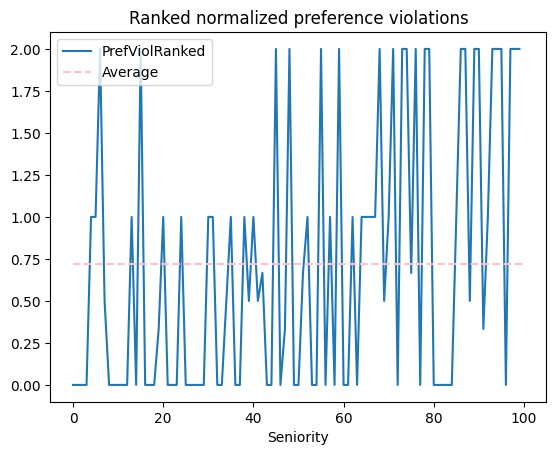

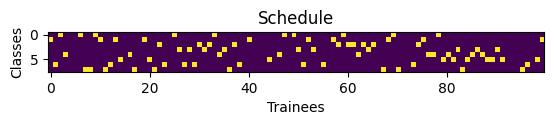

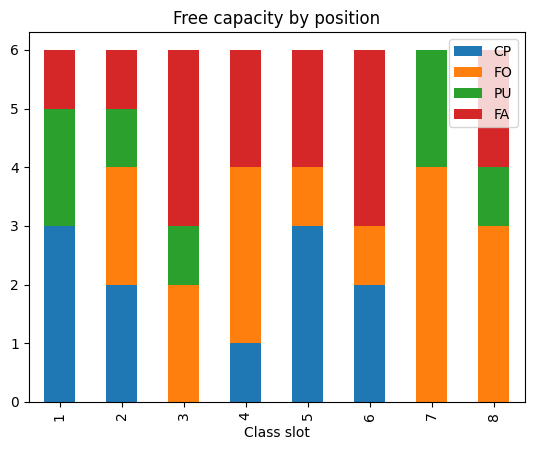

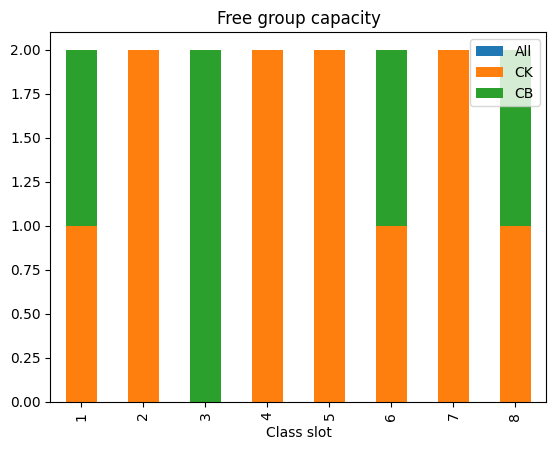

Session language
       1  2  3  4  5  6  7  8
u.val  1  0  0  0  1  0  1  1


In [17]:
pref_sorted_run1 = PresentSolution(ampl, inst)       # We'll investigate reverse seniority violations below

### Averaged preferences

To reduce the average preference violation and improve average "anti-preference", we could sacrifice strict seniority ranking
and minimize the total violation in one go. For this we assign equal
`.objpriority` suffixes for the `PrefViolRanked` and `ReverseSeniority` objectives. In practice, the sum can
be weighted to keep seniority aspirations, for example by the `.objweight` suffixes.

In [18]:
ampl.eval("let {s in SenLevels} PrefViolRanked[s].objpriority := 3;")
ampl.eval("let {e in 1..2, i in I: E[i]==e} ReverseSeniority[e, i].objpriority := 3-e;")

ampl.solve(
    solver=SOLVER,
    mp_options="outlev=0 multiobj=1 tech:timing=1",
    verbose=False,
)

Solve result = solved, time: 0.0838s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.5467
REVERSE SENIORITY:
   ---->> AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  165
2    0
;

   ---->> AS DOMINANCE CONSTRAINTS FROM [1]: OK; 
     ---- 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                  0    1    2         3    4    5    6    7    8    9   ...  \
PrefViolRanked  0.0  0.5  0.0  0.333333  1.0  1.0  2.0  0.5  0.0  0.0  ...   

                 90        91   92   93   94   95   96   97   98   99  
PrefViolRanked  0.0  0.333333  1.0  1.0  0.0  2.0  0.0  2.0  1.0  0.0  

[1 rows x 100 columns]
ReverseSeniority     = index0            1                              ...  2                       \
index1           3   11 13 16 18 20 26 29 30 34  ... 69 71 73 77 83 84 85 87   
ReverseSeniority  0  97  0  0  0  0 

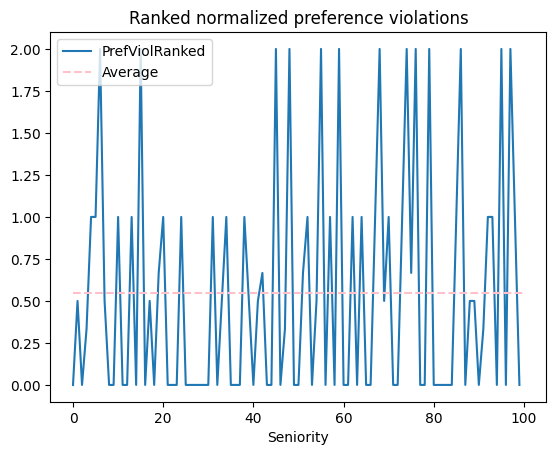

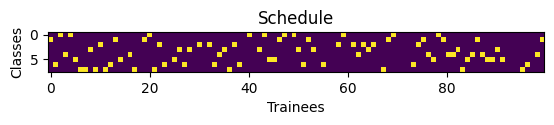

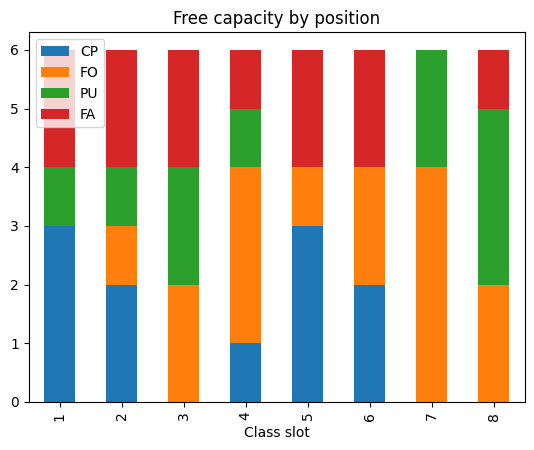

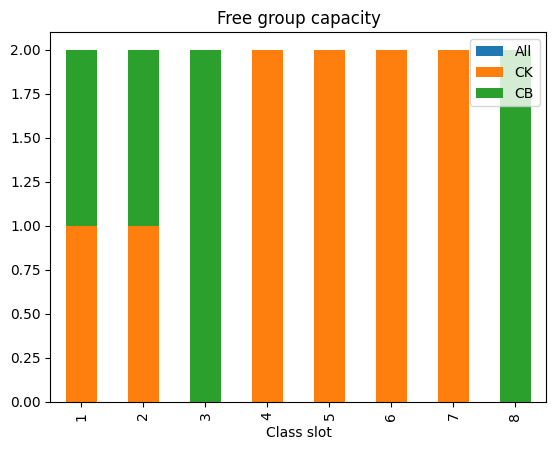

Session language
       1  2  3  4  5  6  7  8
u.val  0  0  0  0  1  0  1  1


In [19]:
print(
    "Solve result = {}, time: {:.3}s\n--------------------------------".format(
        ampl.solve_result, ampl.get_value("Initial.time")
    )
)
pref_sorted_run2 = PresentSolution(ampl, inst)

### Session load balancing

Similar to the last model extension in [1], we post-process the solution
to minimize session load imbalance. We only tackle the imbalance in overall class loads.
For that we add yet another objective function.

In [20]:
%%writefile airtrainee_load_balancing.mod

# Minimize overall session load imbalance
minimize LoadImbalance:
  sum {t in T} abs( sum {i in I: t in V[i]} x[i, t] - sum {i in I, t1 in V[i]} x[i, t1] / card(T) )
  suffix objpriority 0;

Overwriting airtrainee_load_balancing.mod


In [21]:
MODEL_FILE_MIN_LOAD_IMB = "airtrainee_load_balancing.mod"

ampl.read(MODEL_FILE_MIN_LOAD_IMB)
ampl.solve(
    solver=SOLVER,
    mp_options="outlev=0 multiobj=1 tech:timing=1",
    gurobi_options="acc:abs=0",      # force linearization of abs() for Gurobi 11.0.2
    verbose=False,
)

Solve result = solved, time: 0.148s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.5467
REVERSE SENIORITY:
   ---->> AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  165
2    0
;

   ---->> AS DOMINANCE CONSTRAINTS FROM [1]: OK; 
     ---- 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

LoadImbalance        =                0
LoadImbalance  0
PrefViolRanked       =                  0    1    2         3    4    5    6    7    8    9   ...  \
PrefViolRanked  0.0  0.5  0.0  0.333333  1.0  1.0  2.0  0.5  0.0  0.0  ...   

                 90        91   92   93   94   95   96   97   98   99  
PrefViolRanked  0.0  0.333333  1.0  1.0  0.0  2.0  0.0  2.0  1.0  0.0  

[1 rows x 100 columns]
ReverseSeniority     = index0            1                              ...  2                       \
index1           3   11 13 16 18 20 26 29 30 34  ... 69 71 7

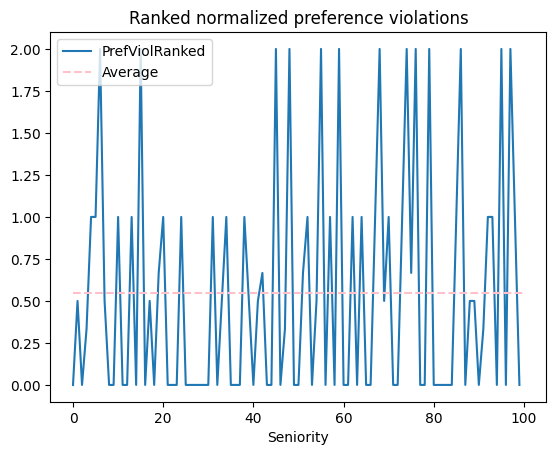

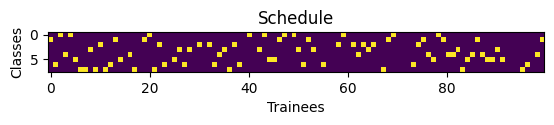

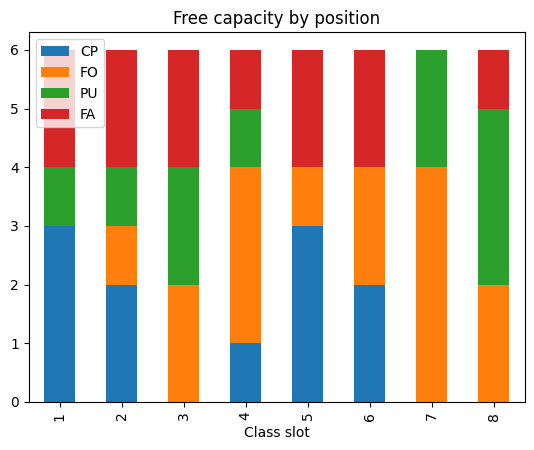

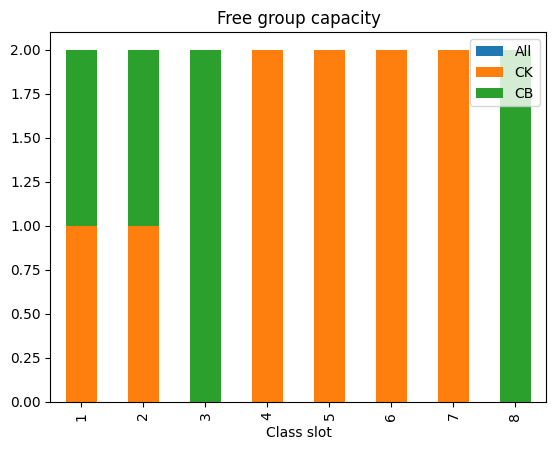

Session language
       1  2  3  4  5  6  7  8
u.val  0  0  0  0  1  0  1  1


In [22]:
print(
    "Solve result = {}, time: {:.3}s\n--------------------------------".format(
        ampl.solve_result, ampl.get_value("Initial.time")
    )
)
pref_sorted_run3 = PresentSolution(ampl, inst)

### Original modeling of reverse seniority

The model in [1] explicitly constrains reverse seniority using $O( |I| |T|)$ additional variables and inequalities, as follows.

In [23]:
%%writefile airtrainee_seniority_reverse_constraints.mod

# Enforce that trainees with expiration E[i]==1 month
# and slot priority Pr[i, t]==0 (don't want this slot)
# and the same position P[i]
# are chosen with the smallest seniority for a given slot,
# and preferred to those with expiration E[i]==2.
s.t. ConOrig_8 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  y[i]>=0.5 ==>
    sum {j in I: E[j]==1 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Similar dominance among those with E[i]==2.
s.t. ConOrig_9 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  y[i]>=0.5 ==>
    sum {j in I: E[j]==2 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Auxiliary variables for more dominance relations
var z {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
var u2 {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;

param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB

# Dominance to the other position in the same group.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_23.)
# Constraints (22)-(25) are an extension of (8).
s.t. ConOrig_22 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  (z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==1 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    + sum {j in I: E[j]==2 && P[j]!=P[i]
           && G[j]==G[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==1
s.t. ConOrig_23 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAX[P[i]];

# Dominance to the other group.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_25.)
s.t. ConOrig_24 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  (u2[i, t]<0.5 && z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==1 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
    + sum {j in I: E[j]==2 && G[j]!=G[i]
           && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain u2 for E[i]==1
s.t. ConOrig_25 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && G[j]==G[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[G[i]];

## The below constraints (26)-(29) are an extension of (9),
## similar to (22)-(25).
# Dominance to the other position in the same group for E[i]==2.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_27.)
s.t. ConOrig_26 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  (z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==2 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==2
s.t. ConOrig_27 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    >= MAX[P[i]];

# Dominance to the other group for E[i]==2.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_29.)
s.t. ConOrig_28 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  (u2[i, t]<0.5 && z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==2 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain u2 for E[i]==2
s.t. ConOrig_29 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    >= MAXPlus[G[i]];

Overwriting airtrainee_seniority_reverse_constraints.mod


Solve the old model from scratch.

In [24]:
MODEL_FILES_OLD =     [
        "airtrainee_base.mod",
        "airtrainee_seniority_reverse_constraints.mod",
        "airtrainee_seniority_reverse_PBS.mod",
    ]

ampl = MakeAMPLInstance(MODEL_FILES_OLD, inst)

ampl.solve(
    solver=SOLVER,
    mp_options="outlev=0 multiobj=1 tech:timing=1",
    verbose=False,
)

Solve result = solved, time: 2.69s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.6617
REVERSE SENIORITY:
   ---->> AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  333
2  191
;

   ---->> AS DOMINANCE CONSTRAINTS FROM [1]: OK; 
     ---- 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                  0    1    2    3    4    5    6    7    8    9   ...   90  \
PrefViolRanked  0.0  0.0  0.0  0.0  1.0  1.0  2.0  0.5  0.0  0.0  ...  0.0   

                      91   92   93   94   95   96   97   98   99  
PrefViolRanked  0.333333  1.0  2.0  2.0  2.0  0.0  2.0  2.0  2.0  

[1 rows x 100 columns]
ReverseSeniority     = index0            1                               ...  2                     \
index1           3   11 13 16 18 20 26 29 30  34  ... 69  71 73 77 83 84 85   
ReverseSeniority  0  97  0  0  0  0  0  0  0  94  

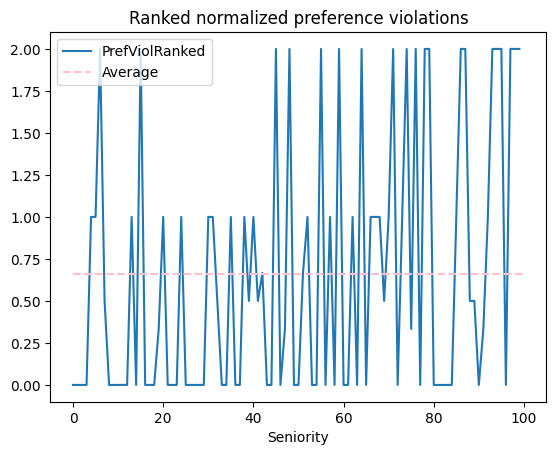

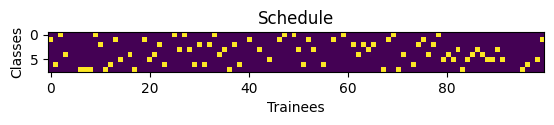

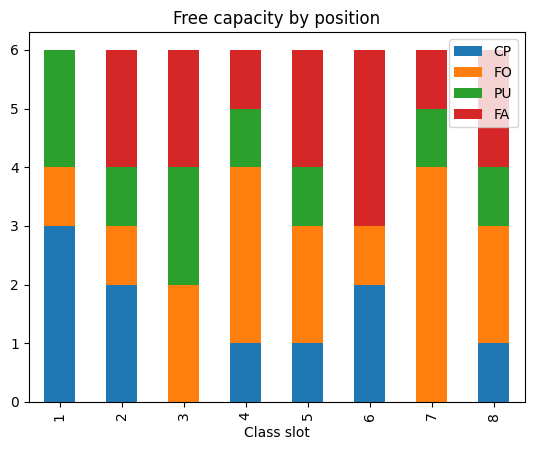

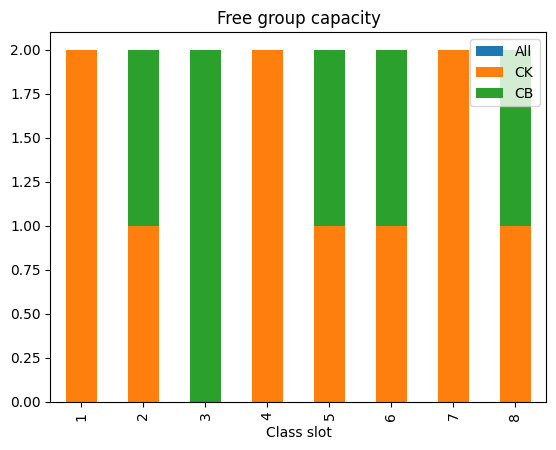

Session language
       1  2  3  4  5  6  7  8
u.val  1  0  0  0  1  0  1  1


In [25]:
print(
    "Solve result = {}, time: {:.3}s\n--------------------------------".format(
        ampl.solve_result, ampl.get_value("Initial.time")
    )
)
pref_sorted_run4 = PresentSolution(ampl, inst)

### Language compatibility

Let us modify the original constraints to consider language assignments, and not require seniority dominance when it cannot be satisfied due to incompatible languages.

In [26]:
%%writefile airtrainee_seniority_reverse_constraints_language.mod

# Enforce that trainees with expiration E[i]==1 month
# and slot priority Pr[i, t]==0 (don't want this slot)
# and the same position P[i]
# are chosen with the smallest seniority for a given slot,
# and preferred to those with expiration E[i]==2.
# Consider language compatibility.
s.t. ConOrig_8 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Similar dominance among those with E[i]==2.
s.t. ConOrig_9 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Auxiliary variables for more dominance relations
var z {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
var u2 {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;

param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB

# Dominance to the other position in the same group.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_23.)
# Constraints (22)-(25) are an extension of (8).
s.t. ConOrig_22 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 || y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]!=P[i]
           && G[j]==G[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain z for E[i]==1
s.t. ConOrig_23 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAX[P[i]];

# Dominance to the other group.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_25.)
s.t. ConOrig_24 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && G[j]!=G[i]
           && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==1
s.t. ConOrig_25 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && G[j]==G[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[G[i]];

## The below constraints (26)-(29) are an extension of (9),
## similar to (22)-(25).
# Dominance to the other position in the same group for E[i]==2.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_27.)
s.t. ConOrig_26 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 || y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==2
s.t. ConOrig_27 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    >= MAX[P[i]];

# Dominance to the other group for E[i]==2.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_29.)
s.t. ConOrig_28 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==2
s.t. ConOrig_29 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    >= MAXPlus[G[i]];

Overwriting airtrainee_seniority_reverse_constraints_language.mod


In [27]:
ampl = MakeAMPLInstance(
    [
        "airtrainee_base.mod",
        "airtrainee_seniority_reverse_constraints_language.mod",
        "airtrainee_seniority_reverse_PBS.mod",
    ],
    inst,
)

ampl.solve(
    solver=SOLVER,
    mp_options="outlev=0 multiobj=1 tech:timing=1",
    verbose=False,
)

Solve result = solved, time: 3.66s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.6617
REVERSE SENIORITY:
   ---->> AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  333
2  191
;

   ---->> AS DOMINANCE CONSTRAINTS FROM [1]: OK; 
     ---- 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                  0    1    2    3    4    5    6    7    8    9   ...   90  \
PrefViolRanked  0.0  0.0  0.0  0.0  1.0  1.0  2.0  0.5  0.0  0.0  ...  0.0   

                      91   92   93   94   95   96   97   98   99  
PrefViolRanked  0.333333  1.0  2.0  2.0  2.0  0.0  2.0  2.0  2.0  

[1 rows x 100 columns]
ReverseSeniority     = index0            1                               ...  2                     \
index1           3   11 13 16 18 20 26 29 30  34  ... 69  71 73 77 83 84 85   
ReverseSeniority  0  97  0  0  0  0  0  0  0  94  

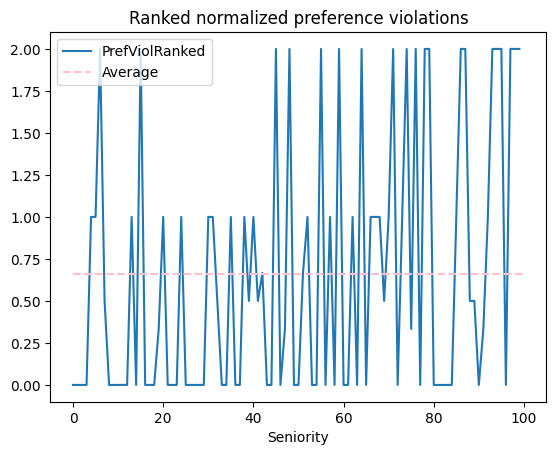

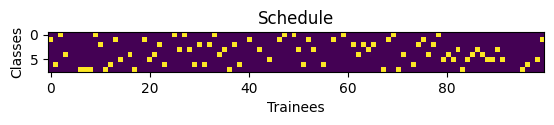

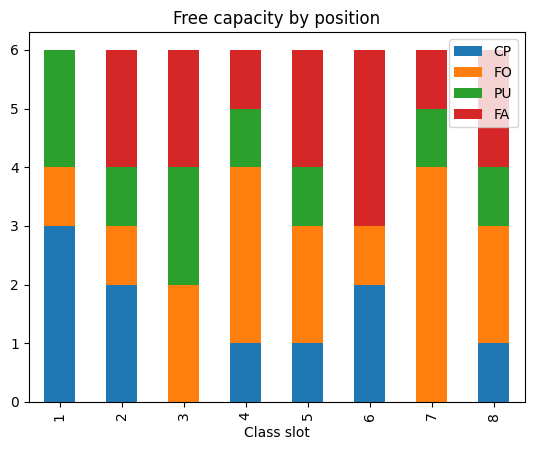

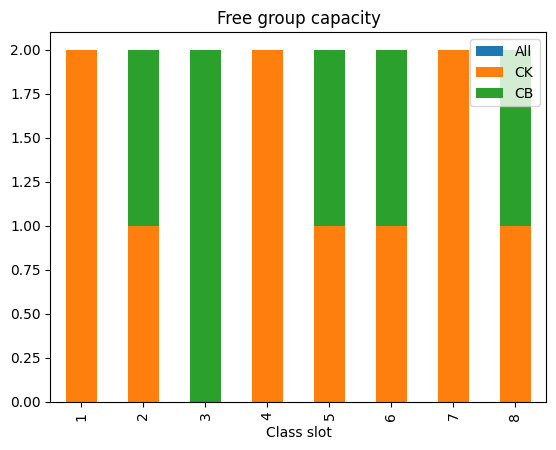

Session language
       1  2  3  4  5  6  7  8
u.val  1  0  0  0  1  0  1  1


In [28]:
print(
    "Solve result = {}, time: {:.3}s\n--------------------------------".format(
        ampl.solve_result, ampl.get_value("Initial.time")
    )
)
pref_sorted_run5 = PresentSolution(ampl, inst)

### Consider all capacities

Let us consider other capacity constraints (group, total) in ConOrig_22, _24, _26, _28. For that we introduce variable `zz` implying full total capacity for a slot.

In [29]:
%%writefile airtrainee_seniority_reverse_constraints_language_fullcapacity.mod

# Enforce that trainees with expiration E[i]==1 month
# and slot priority Pr[i, t]==0 (don't want this slot)
# and the same position P[i]
# are chosen with the smallest seniority for a given slot,
# and preferred to those with expiration E[i]==2.
# Update 1: consider language compatibility.
s.t. ConOrig_8 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Similar dominance among those with E[i]==2.
s.t. ConOrig_9 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Auxiliary variables for more dominance relations
var z {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
var u2 {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
# Update 2: having full total class capacity.
var zz {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;

param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB

# Dominance to the other position in the same group.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_23.)
# Constraints (22)-(25) are an extension of (8).
# Update 2: consider group and total class capacities.
s.t. ConOrig_22 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]!=P[i]
           && G[j]==G[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain z for E[i]==1
s.t. ConOrig_23 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAX[P[i]];

# Dominance to the other group.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_25.)
s.t. ConOrig_24 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && G[j]!=G[i]
           && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==1
s.t. ConOrig_25 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && G[j]==G[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[G[i]];

s.t. ConOrig_25_ZZ {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  zz[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[1];

## The below constraints (26)-(29) are an extension of (9),
## similar to (22)-(25).
# Dominance to the other position in the same group for E[i]==2.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_27.)
s.t. ConOrig_26 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==2
s.t. ConOrig_27 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    >= MAX[P[i]];

# Dominance to the other group for E[i]==2.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_29.)
s.t. ConOrig_28 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==2
s.t. ConOrig_29 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    >= MAXPlus[G[i]];

s.t. ConOrig_29_ZZ {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  zz[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && t in V[j] } x[j, t]
    >= MAXPlus[1];

Overwriting airtrainee_seniority_reverse_constraints_language_fullcapacity.mod


In [30]:
ampl = MakeAMPLInstance(
    [
        "airtrainee_base.mod",
        "airtrainee_seniority_reverse_constraints_language_fullcapacity.mod",
        "airtrainee_seniority_reverse_PBS.mod",
    ],
    inst,
)

ampl.solve(
    solver=SOLVER,
    mp_options="outlev=0 multiobj=1 tech:timing=1",
    verbose=False,
)

Solve result = solved, time: 3.73s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.6617
REVERSE SENIORITY:
   ---->> AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  333
2  191
;

   ---->> AS DOMINANCE CONSTRAINTS FROM [1]: OK; 
     ---- 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                  0    1    2    3    4    5    6    7    8    9   ...   90  \
PrefViolRanked  0.0  0.0  0.0  0.0  1.0  1.0  2.0  0.5  0.0  0.0  ...  0.0   

                      91   92   93   94   95   96   97   98   99  
PrefViolRanked  0.333333  1.0  2.0  2.0  2.0  0.0  2.0  2.0  2.0  

[1 rows x 100 columns]
ReverseSeniority     = index0            1                               ...  2                     \
index1           3   11 13 16 18 20 26 29 30  34  ... 69  71 73 77 83 84 85   
ReverseSeniority  0  97  0  0  0  0  0  0  0  94  

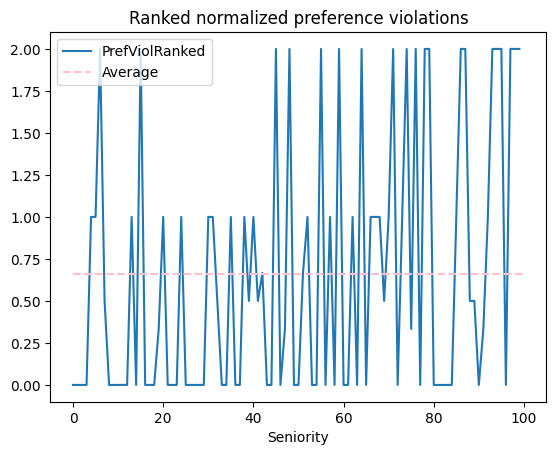

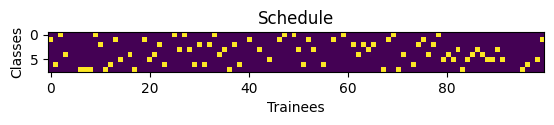

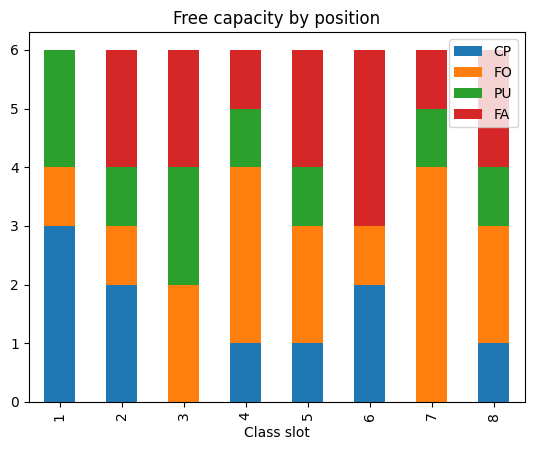

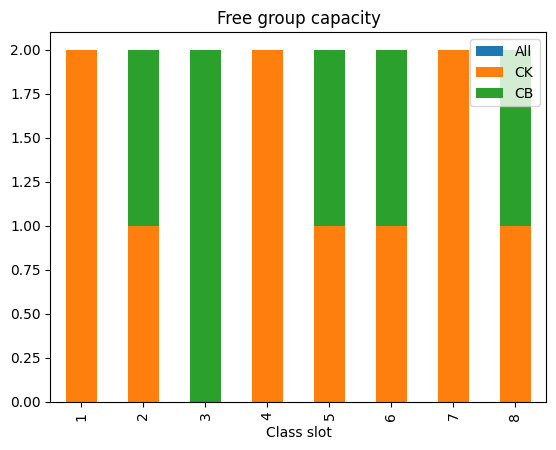

Session language
       1  2  3  4  5  6  7  8
u.val  1  0  0  0  1  0  1  1


In [31]:
print(
    "Solve result = {}, time: {:.3}s\n--------------------------------".format(
        ampl.solve_result, ampl.get_value("Initial.time")
    )
)
pref_sorted_run6 = PresentSolution(ampl, inst)

### Discussion

For some examples we can observe violations of the original reverse seniority constraints (see the text output in the solution evaluation.) One such instance is `seed=1234`, `N=100`, `T=8`.

The reason is that these constraints can contradict with the direct preferences. Let us lexicographically compare the direct preference violations from runs 1 and 4.

In [32]:
def LexCmp(dict1, dict2):
    list1 = sorted(list(dict1.items()), key=lambda x:x[0], reverse=True)
    list2 = sorted(list(dict2.items()), key=lambda x:x[0], reverse=True)
    assert len(list1)==len(list2)               ## Assume equal sizes
    for i in range(len(list1)):
        assert list1[i][0]==list2[i][0]         ## Equal keys
        print("  Priority {}:     {} vs {}".format(list1[i][0], list1[i][1], list2[i][1]))
        if list1[i][1] < list2[i][1]-1e-5:
            print("Ranking 1 is lexicographically smaller.")
            return
        if list1[i][1] > list2[i][1]+1e-5:
            print("Ranking 1 is lexicographically larger.")
            return
    print("Both rankings are equal.")

print("Ranked prefernce violations for runs 1 and 4:")
LexCmp(pref_sorted_run1, pref_sorted_run4)

Ranked prefernce violations for runs 1 and 4:
  Priority 298:     0.0 vs 0.0
  Priority 297:     0.0 vs 0.0
  Priority 296:     0.0 vs 0.0
  Priority 295:     0.0 vs 0.0
  Priority 294:     1.0 vs 1.0
  Priority 293:     1.0 vs 1.0
  Priority 292:     2.0 vs 2.0
  Priority 291:     0.5 vs 0.5
  Priority 290:     0.0 vs 0.0
  Priority 289:     0.0 vs 0.0
  Priority 288:     0.0 vs 0.0
  Priority 287:     0.0 vs 0.0
  Priority 286:     0.0 vs 0.0
  Priority 285:     1.0 vs 1.0
  Priority 284:     0.0 vs 0.0
  Priority 283:     2.0 vs 2.0
  Priority 282:     0.0 vs 0.0
  Priority 281:     0.0 vs 0.0
  Priority 280:     0.0 vs 0.0
  Priority 279:     0.33333333333333337 vs 0.33333333333333337
  Priority 278:     1.0 vs 1.0
  Priority 277:     0.0 vs 0.0
  Priority 276:     0.0 vs 0.0
  Priority 275:     0.0 vs 0.0
  Priority 274:     1.0 vs 1.0
  Priority 273:     0.0 vs 0.0
  Priority 272:     0.0 vs 0.0
  Priority 271:     0.0 vs 0.0
  Priority 270:     0.0 vs 0.0
  Priority 269:     0.0

If the ranked vector of preference violations for the new model is lexicographically smaller, this a sign of such contradiction.

It is up to the decision-maker to choose what's important, but [1] states that the direct preferences are more important than reverse seniority. If necessary, selected revserse seniority relations can be added *apriori* or in a lazy fashion.

## Experiment

We solve pseudo-random instances of different sizes, aiming to validate our approach. We aim to produce results corresponding to Tables 7 and 8 in [1].

In [33]:
import timeit

In [34]:
class Experiment:
    def __init__(self, n_first, n_last, n_step, T_factor, N_repeats):
        self.n_first = n_first
        self.n_last = n_last;
        self.n_step = n_step
        self.T_factor = T_factor
        self.N_repeats = N_repeats          # Repeats for each n

    def SolveAndPrint(self, inst, files, stats):
        ampl = MakeAMPLInstance(files, inst)
        # ampl.export_data("airtrainee_infeas_200.dat")
        tm = timeit.timeit(lambda:
                ampl.solve(
                    solver=SOLVER,
                    mp_options="outlev=0 multiobj=1",  # mp_options for MP-based solvers
                    gurobi_options="acc:abs=0",        # force linearization of abs() for Gurobi 11.0.2
                    verbose=False,
                ), number=1)
        stats.time_.append(tm)
        AddStats(ampl, inst, stats)
        if (ampl.solve_result != "solved"):
            print("SOLVE RESULT:", ampl.solve_result, end=" !!\t")
        print("{:#.2f},  {},  {:#.2f},  {:#.2f}".format(tm,
                        "Violated" if stats.if_viol_sen_reverse_[-1] else "OK",
                        stats.viol_pref_[-1], stats.viol_balance_[-1]),
              end="")
    
    def Run(self, seed, extra_files=[]):
        print("==========================================================================================")
        print("========== Experiment for n in range({}, {}, {}); {} repeats; SOLVER: {} ==========".
              format(self.n_first, self.n_last+1, self.n_step, self.N_repeats, SOLVER))
        print("==========================================================================================")
        stats = []
        mfiles_new = MODEL_FILES_NEW + extra_files
        mfiles_old = MODEL_FILES_OLD + extra_files
        for n in range(self.n_first, self.n_last+1, self.n_step):
            rng = np.random.default_rng(seed)
            genpar = InstGenParams(n, math.floor(n * self.T_factor))  # With the Demo license, set up to 50 trainees
            print("\n=================================================================")
            print("================== Running for n = {}, T = {} ===================".
                  format(n, genpar.T))
            print("====== Instance\t TIME, REV_SEN_CHECK, VIOL_PREF, VIOL_BALANCE ======")
            stats.append([SolveStats(), SolveStats()])
            for i_repeat in range(self.N_repeats):
                inst = GenInstance(genpar, rng)
                print("       {}. \t".format(i_repeat+1), end="")
                print("NEW MODEL:\t", end="", flush=True)
                self.SolveAndPrint(inst, mfiles_new, stats[-1][0])
                print("\t\tOLD MODEL:\t", end="", flush=True)
                self.SolveAndPrint(inst, mfiles_old, stats[-1][1])
                print("")

### Default setting

The first run of the experiment aims at Table 7 in [1], which benchmarks the default setting.

In [35]:
seed = 1234

exper = Experiment(100,200,100, 1 / 12, 3)

In [36]:
exper.Run(seed)

========== Experiment for n in range(100, 201, 100); 3 repeats; SOLVER: highs ==========

================== Running for n = 100, T = 8 ===================
====== Instance	 TIME, REV_SEN_CHECK, VIOL_PREF, VIOL_BALANCE ======
       1. 	NEW MODEL:	0.63,  Violated,  0.72,  0.00		OLD MODEL:	2.62,  OK,  0.66,  0.00
       2. 	NEW MODEL:	SOLVE RESULT: infeasible !!	0.01,  OK,  0.99,  0.88		OLD MODEL:	SOLVE RESULT: infeasible !!	0.06,  OK,  0.99,  0.88
       3. 	NEW MODEL:	1.05,  Violated,  0.87,  0.00		OLD MODEL:	2.82,  OK,  0.79,  0.00

================== Running for n = 200, T = 16 ===================
====== Instance	 TIME, REV_SEN_CHECK, VIOL_PREF, VIOL_BALANCE ======
       1. 	NEW MODEL:	6.43,  OK,  0.52,  0.00		OLD MODEL:	85.47,  OK,  0.52,  0.00
       2. 	NEW MODEL:	SOLVE RESULT: infeasible !!	0.03,  OK,  1.02,  0.88		OLD MODEL:	SOLVE RESULT: infeasible !!	0.17,  OK,  1.02,  0.88
       3. 	NEW MODEL:	SOLVE RESULT: infeasible !!	0.03,  OK,  1.01,  0.81		OLD MODEL:	SOLVE RESULT: inf

### Session load balancing

This run additionally minimizes session load imbalance, corresponding to Table 8 in [1].

In [37]:
exper.Run(seed, [MODEL_FILE_MIN_LOAD_IMB])

========== Experiment for n in range(100, 201, 100); 3 repeats; SOLVER: highs ==========

================== Running for n = 100, T = 8 ===================
====== Instance	 TIME, REV_SEN_CHECK, VIOL_PREF, VIOL_BALANCE ======
       1. 	NEW MODEL:	0.75,  Violated,  0.72,  0.00		OLD MODEL:	2.78,  OK,  0.66,  0.00
       2. 	NEW MODEL:	SOLVE RESULT: infeasible !!	0.02,  OK,  0.99,  0.88		OLD MODEL:	SOLVE RESULT: infeasible !!	0.07,  OK,  0.99,  0.88
       3. 	NEW MODEL:	1.22,  Violated,  0.87,  0.00		OLD MODEL:	3.05,  OK,  0.79,  0.00

================== Running for n = 200, T = 16 ===================
====== Instance	 TIME, REV_SEN_CHECK, VIOL_PREF, VIOL_BALANCE ======
       1. 	NEW MODEL:	9.46,  OK,  0.52,  0.00		OLD MODEL:	83.52,  OK,  0.52,  0.00
       2. 	NEW MODEL:	SOLVE RESULT: infeasible !!	0.09,  OK,  1.02,  0.88		OLD MODEL:	SOLVE RESULT: infeasible !!	0.24,  OK,  1.02,  0.88
       3. 	NEW MODEL:	SOLVE RESULT: infeasible !!	0.10,  OK,  1.01,  0.81		OLD MODEL:	SOLVE RESULT: inf

## Conclusions

We studied an aircrew trainee scheduling problem from [1] with seniority-ranked preferences and seniority- and expiration-ranked "anti-preferences" for class assignments. We proposed a Priority Bidding System-style modeling for the "anti-preferences" part. It offers greater satisfaction for the direct preferences. For "anti-preferences", while able to resolve a 'pitfall' described in [1], it can be weaker than the strict constraints from [1], because they can contradict with the direct preferences (which are said to be of highest priority however.)

The new approach is simpler to model (lexicographic auxiliary objective functions) and more efficient to solve. Even for the original model from [1], solving times have been greatly improved by using a multi-objective approach.